In [1]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
# Covariance matrix parameters

length_scale = 200.0
variance = 2500.0
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

In [3]:
# Sample points for prediction
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # 100 points from -5 to 5

# Observed data points
X_train = np.linspace(-10, 10, 11).reshape(-1, 1)  # 10 training points
#y_train = np.sin(X_train).flatten()  # Example function values at training points
y_train = -np.square(X_train).flatten()  # Example function values at training points

y_train[1] = -100
y_train[2] = -80
y_train[3] = -50
y_train[7] = -40
y_train[8] = -90
y_train[9] = -100

y_train = y_train * 10

# Sample points for prediction
X = np.linspace(-1000, 1000, 100).reshape(-1, 1)  # 100 points from -5 to 5
# Observed data points
X_train = np.linspace(-1000, 1000, 11).reshape(-1, 1)  # 10 training points

In [4]:
WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

WhiteKernel(noise_level=1)

In [5]:
# Kernels

# RBF kernel function
def rbf_kernel(x1, x2, length_scale=length_scale, variance=variance):
    sqdist = np.sum((x1 - x2)**2)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):
    # Convert inputs to numpy arrays if they are not already
    #x1 = np.atleast_2d(x1)
    #x2 = np.atleast_2d(x2)
    
    # Calculate the Euclidean distance between points
    d = np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    
    # Handle the special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)
    
    # Compute the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
        
    # Handle the case when distance is zero to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)
    
    return variance * matern_value

C:\Users\cco\AppData\Local\Temp\ipykernel_39032\4031991827.py:24: RuntimeWarning: invalid value encountered in double_scalars
  matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)


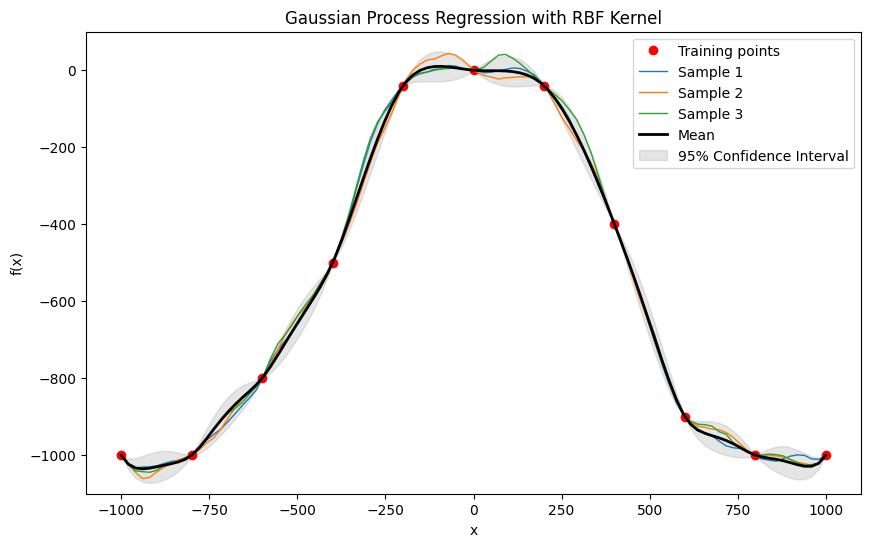

In [6]:
# GAUSSIAN PROCESS EXAMPLE 

# Covariance matrix for the training points
K = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i, j] = matern_kernel(X_train[i], X_train[j], length_scale, nu, variance)

# Covariance matrix between the training points and the test points
K_s = np.zeros((len(X_train), len(X)))
for i in range(len(X_train)):
    for j in range(len(X)):
        K_s[i, j] = matern_kernel(X_train[i], X[j], length_scale, nu, variance)

# Covariance matrix for the test points
K_ss = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K_ss[i, j] = matern_kernel(X[i], X[j], length_scale, nu, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))  # Add a small noise term for numerical stability

# Mean of the conditioned GP
mu_s = K_s.T.dot(K_inv).dot(y_train)

# Covariance of the conditioned GP
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Samples from the conditioned GP
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=1)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Gaussian Process Regression with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()
plt.show()


d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


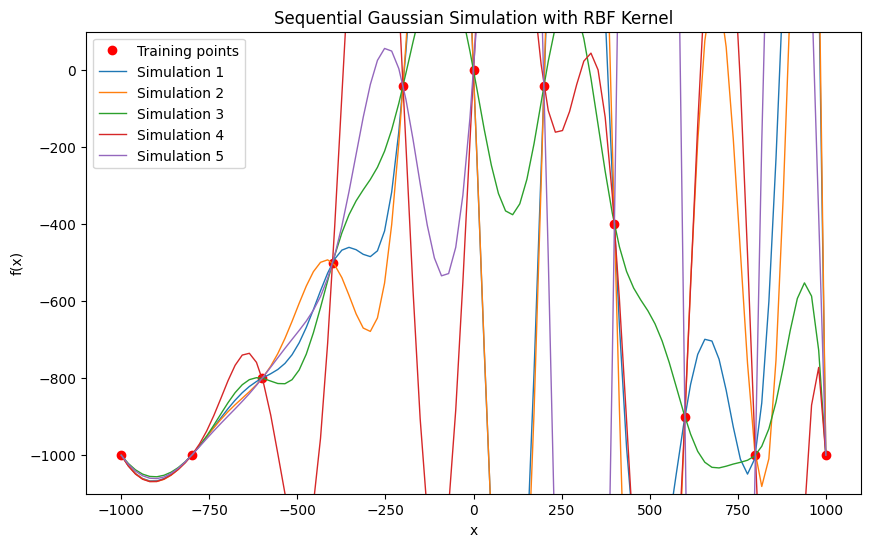

In [7]:
# SEQUENTIAL GAUSSIAN SIMULATION

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_s = np.round_(K_s, 8)
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            sigma = np.max((K_ss - K_s.T.dot(K_train_inv).dot(K_s), 0))
            #sigma = np.abs(K_ss - K_s.T.dot(K_train_inv).dot(K_s))
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
            
        simulations[s, :] = y_sim
    return simulations

# Perform SGS
num_simulations = 5
simulations = sequential_gaussian_simulation(X_train, y_train, X, rbf_kernel, length_scale, variance, num_simulations)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=1)
plt.title('Sequential Gaussian Simulation with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()
plt.show()


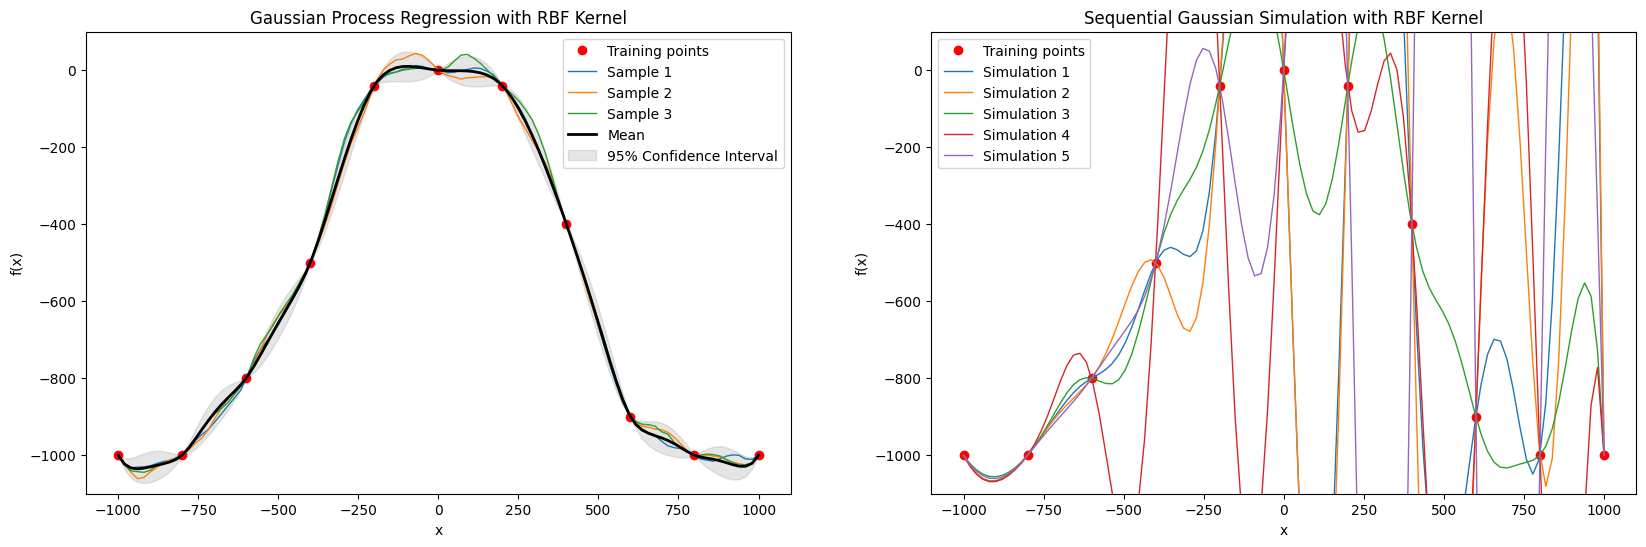

In [8]:
# PLOT GP AND SGS COMPARISON

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=1)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Gaussian Process Regression with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=1)
plt.title('Sequential Gaussian Simulation with RBF Kernel')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.show()


### https://pylops.readthedocs.io/en/stable/tutorials/solvers.html

NameError: name 'N' is not defined

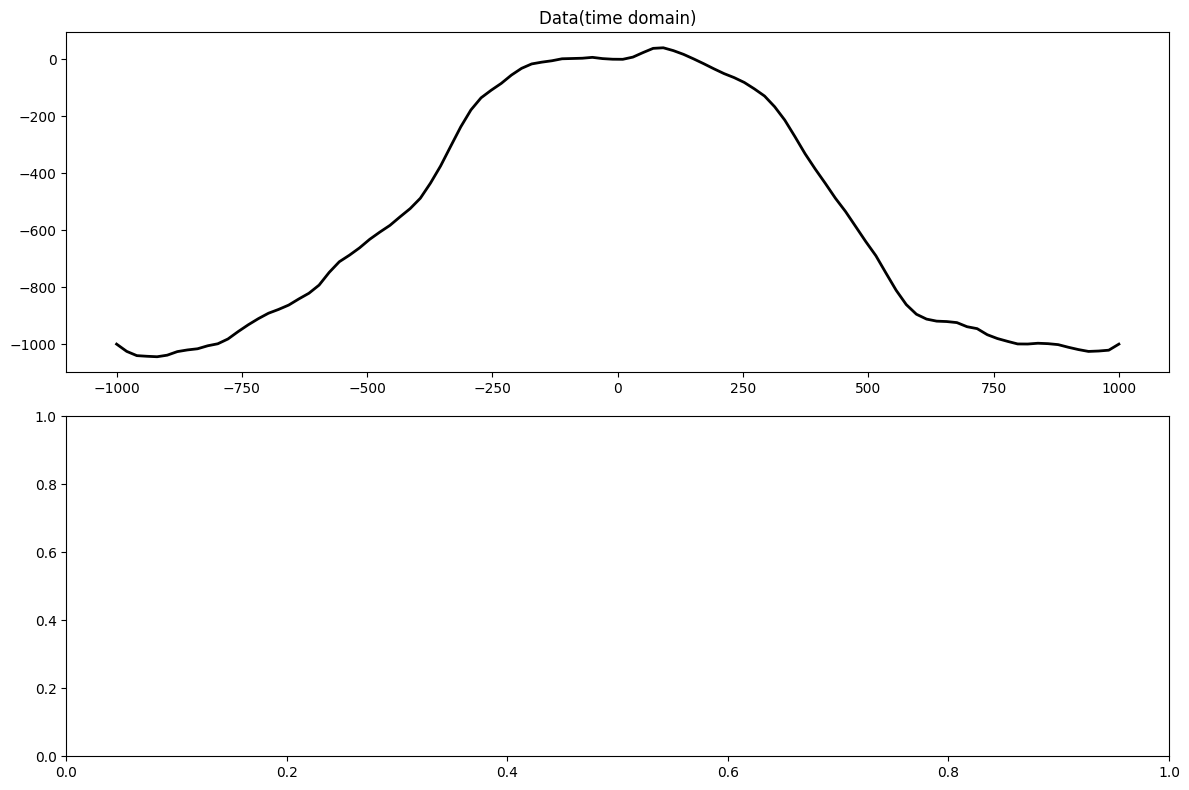

In [9]:
import pylops

plt.close("all")
np.random.seed(10)

t= X
x = samples[2]

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t, x, "k", lw=2)
axs[0].set_title("Data(time domain)")
axs[0].axis("tight")
plt.tight_layout()

# subsampling locations
perc_subsampling = 0.2
Nsub = int(np.round(N * perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = pylops.Restriction(N, iava, dtype="float64")

y = Rop * x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(12, 4))
plt.plot(t, x, "k", lw=3)
plt.plot(t, x, ".k", ms=20, label="all samples")
plt.plot(t, ymask, ".g", ms=15, label="available samples")
plt.legend()
plt.title("Data restriction")
plt.tight_layout()

In [ ]:
# Create regularization operator
D2op = pylops.SecondDerivative(N, dtype="float64")

# Regularized inversion
epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [D2op], epsI=epsI, epsRs=[epsR], **dict(maxiter=50)
)[0]

In [ ]:
ND2op = pylops.MatrixMult((D2op.H * D2op).tosparse())  # mimic fast D^T D

xne1 = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [], NRegs=[ND2op], epsI=epsI, epsNRs=[epsR], **dict(maxiter=50)
)[0]

In [ ]:
xreg = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [D2op],
    epsRs=[np.sqrt(0.1)],
    **dict(damp=np.sqrt(1e-4), iter_lim=50, show=0)
)[0]

In [ ]:
# Create regularization operator
Sop = pylops.Smoothing1D(nsmooth=11, dims=[N], dtype="float64")

# Invert for interpolated signal
xprec = pylops.optimization.leastsquares.preconditioned_inversion(
    Rop, y, Sop, **dict(damp=np.sqrt(1e-9), iter_lim=20, show=0)
)[0]

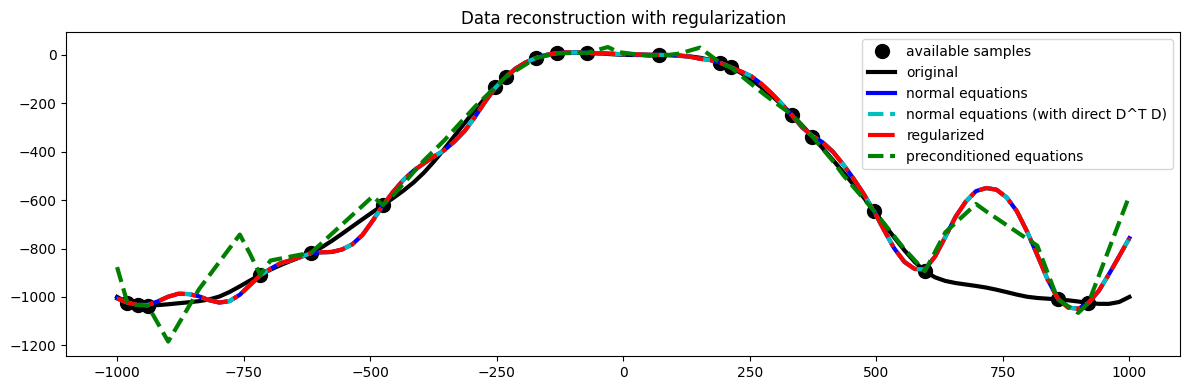

In [ ]:
# sphinx_gallery_thumbnail_number=4
fig = plt.figure(figsize=(12, 4))
plt.plot(t[iava], y, ".k", ms=20, label="available samples")
plt.plot(t, x, "k", lw=3, label="original")
plt.plot(t, xne, "b", lw=3, label="normal equations")
plt.plot(t, xne1, "--c", lw=3, label="normal equations (with direct D^T D)")
plt.plot(t, xreg, "-.r", lw=3, label="regularized")
plt.plot(t, xprec, "--g", lw=3, label="preconditioned equations")
plt.legend()
plt.title("Data reconstruction with regularization")

#subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
#subax.plot(t[iava], y, ".k", ms=20)
#subax.plot(t, x, "k", lw=3)
#subax.plot(t, xne, "b", lw=3)
#subax.plot(t, xne1, "--c", lw=3)
#subax.plot(t, xreg, "-.r", lw=3)
#subax.plot(t, xprec, "--g", lw=3)
#subax.set_xlim(0.05, 0.3)
plt.tight_layout()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer 
import gstatsim as gs
import skgstat as skg
from skgstat import models
import random

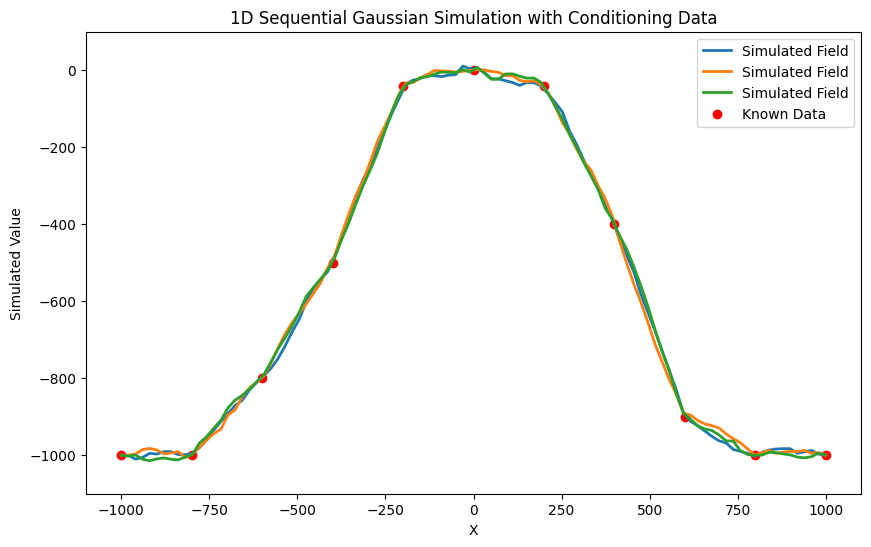

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, cho_solve

nx = len(X)

# Variogram model (spherical model as an example)
def variogram(h, range_a, sill, nugget):
    """ Spherical variogram model """
    h = np.abs(h)
    return np.where(h < range_a,
                    nugget + sill * (1.5 * (h / range_a) - 0.5 * (h / range_a)**3),
                    nugget + sill)

# Variogram parameters
range_a = 1500.0  # Range of the variogram
sill = 1000.0  # Sill of the variogram
nugget = 100 # Nugget effect

# Perform SGS with conditioning data
num_simulations = 3
simulations = np.zeros((num_simulations, nx))

for s in range(num_simulations):
    y_sim = np.zeros(nx)
    for i in range(nx):
        X_all = np.vstack([X_train, X[:i+1]])
        
        # Calculate the covariance matrix using the variogram
        h = cdist(X_all, X_all)
        cov_matrix = sill - variogram(h, range_a, sill, nugget)
        
        # Split the covariance matrix
        cov_11 = cov_matrix[:len(X_train)+i, :len(X_train)+i]
        cov_12 = cov_matrix[:len(X_train)+i, len(X_train)+i:len(X_train)+i+1]
        cov_22 = cov_matrix[len(X_train)+i:len(X_train)+i+1, len(X_train)+i:len(X_train)+i+1]
        
        # Calculate the mean and variance for the new point
        mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([y_train, y_sim[:i]])
        variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12
        
        # Draw a random sample from the normal distribution
        y_sim[i] = np.random.normal(mean, np.sqrt(variance))
    
    simulations[s, :] = y_sim

# Plot the simulation result
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(X, simulations[i], label='Simulated Field', lw=2)
plt.scatter(X_train, y_train, c='red', label='Known Data')
plt.title('1D Sequential Gaussian Simulation with Conditioning Data')
plt.xlabel('X')
plt.ylabel('Simulated Value')
plt.legend()
#plt.grid(True)
plt.ylim((-1100, 100))
plt.show()
